In [2]:
library(dplyr)
library(geosphere)
# read csv
failed_airport <- read.csv("failed_downloads.csv")
airport_data <- read.csv("Filtered_Airport_US_Unique.csv")
station_data <- read.csv("ghcnh-station-list.csv", header = FALSE, stringsAsFactors = FALSE)

### Step1:  Filter airport_data to include only rows with these failed airport codes

In [3]:
failed_airport_codes <- unique(unlist(failed_airport))
filtered_failed_airports <- airport_data %>%
  filter(AIRPORT %in% failed_airport_codes)
head(filtered_failed_airports )
cat("Number of airports after filtering:", nrow(filtered_failed_airports ), "\n")

,AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE
,<chr>,<int>,<dbl>,<dbl>
1,ACY,10158,39.45694,-74.57778
2,ADK,10165,51.88069,-176.64463
3,AEX,10185,31.32583,-92.54778
4,AKN,10245,58.67708,-156.65014
5,BGR,10581,44.80764,-68.82792
6,BIS,10627,46.77583,-100.74917


Number of airports after filtering: 31 


### Step2: Calculate the three closest stations for each airport in filtered_failed_airports

In [4]:
haversine <- function(lat1, lon1, lat2, lon2) {
  R <- 6371  # Earth's radius in kilometers
  dLat <- (lat2 - lat1) * pi / 180
  dLon <- (lon2 - lon1) * pi / 180
  lat1 <- lat1 * pi / 180
  lat2 <- lat2 * pi / 180 
  a <- sin(dLat / 2) * sin(dLat / 2) + sin(dLon / 2) * sin(dLon / 2) * cos(lat1) * cos(lat2)
  c <- 2 * atan2(sqrt(a), sqrt(1 - a))
  return(R * c)  # Return distance in kilometers
}

In [5]:
# Function to find the three nearest stations and their distances
find_three_nearest_stations <- function(lat, lon, station_data) {
  distances <- haversine(lat, lon, station_data[,2],  station_data[,3])
  
  # Check if all distances are numeric
  is_numeric <- all(sapply(distances, is.numeric))
  if (!is_numeric) {
    stop("Some distances are not numeric.")
  }
  
  # Check for NA values and their indices
  na_indices <- which(is.na(distances))
  if (length(na_indices) > 0) {
    cat("Warning: NA values found in distances calculation at indices:", na_indices, "\n")
    distances <- distances[!is.na(distances)]  # Remove NA values
  }
  
  # Get indices of the three nearest stations
  nearest_indices <- order(distances)[1:3]
  
  # Extract station IDs and distances for the three nearest stations
  nearest_stations <- station_data$STATION[nearest_indices]
  nearest_distances <- distances[nearest_indices]
  
  return(list(stations = nearest_stations, distances = nearest_distances))
}

In [6]:
# Function to find the three nearest stations and their distances
find_three_nearest_stations <- function(lat, lon, station_data) {
  distances <- haversine(lat, lon, station_data[, 2], station_data[, 3])
  
  # Remove NA values from distances
  distances <- distances[!is.na(distances)]
  
  # Get indices of the three nearest stations, filling with NA if fewer than 3
  nearest_indices <- order(distances)[1:min(3, length(distances))]
  
  nearest_stations <- if(length(nearest_indices) < 3) {
    c(station_data[nearest_indices, 1], rep(NA, 3 - length(nearest_indices)))
  } else {
    station_data[nearest_indices, 1]
  }
  
  nearest_distances <- if(length(nearest_indices) < 3) {
    c(distances[nearest_indices], rep(NA, 3 - length(nearest_indices)))
  } else {
    distances[nearest_indices]
  }
  
  return(c(nearest_stations, nearest_distances))
}

# Apply the function to each airport in filtered_failed_airports
result <- lapply(1:nrow(filtered_failed_airports), function(i) {
  nearest_info <- find_three_nearest_stations(
    filtered_failed_airports$LATITUDE[i],
    filtered_failed_airports$LONGITUDE[i],
    station_data
  )
  return(nearest_info)
})

# Convert the result to a data frame with specific column names
result_df <- as.data.frame(do.call(rbind, result), stringsAsFactors = FALSE)
colnames(result_df) <- c("Station_1", "Station_2", "Station_3", "Distance_1", "Distance_2", "Distance_3")

# Combine with filtered_failed_airports
final_data <- cbind(filtered_failed_airports, result_df)

# Print the first few rows of the final result
head(final_data)

,AIRPORT,AIRPORT_ID,LATITUDE,LONGITUDE,Station_1,Station_2,Station_3,Distance_1,Distance_2,Distance_3
,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACY,10158,39.45694,-74.57778,USW00013753,USW00093730,USL000JCRN4,0.906129019844005,1.08943054764151,13.867213026282
2,ADK,10165,51.88069,-176.64463,USW00025701,USW00025704,USL000ADKA2,0.468847133476551,0.468847133476551,1.55652029846687
3,AEX,10185,31.32583,-92.54778,USW00013934,USW00093915,USW00013935,1.03728609817514,1.42430461397731,26.3547812649473
4,AKN,10245,58.67708,-156.65014,USU070326-1,USW00025503,USI0000PFWS,0.787671842757615,1.22615503571592,20.3773182363612
5,BGR,10581,44.80764,-68.82792,USW00014601,USW00014606,USC00176435,1.22662804910096,1.31803654807744,14.8142729233407
6,BIS,10627,46.77583,-100.74917,USW00094071,USW00024011,USW00000296,1.01756163972181,1.03507946991937,11.0560642779118


In [7]:
# Save the final data to a CSV file
write.csv(final_data, "Falied_Airport_with_Nearest_Station.csv", row.names = FALSE)
cat("Airport data with nearest station information has been saved to 'Falied_Airport_with_Nearest_Station.csv'\n")

Airport data with nearest station information has been saved to 'Falied_Airport_with_Nearest_Station.csv'


### Step 3: Check the distance is reasonable or not

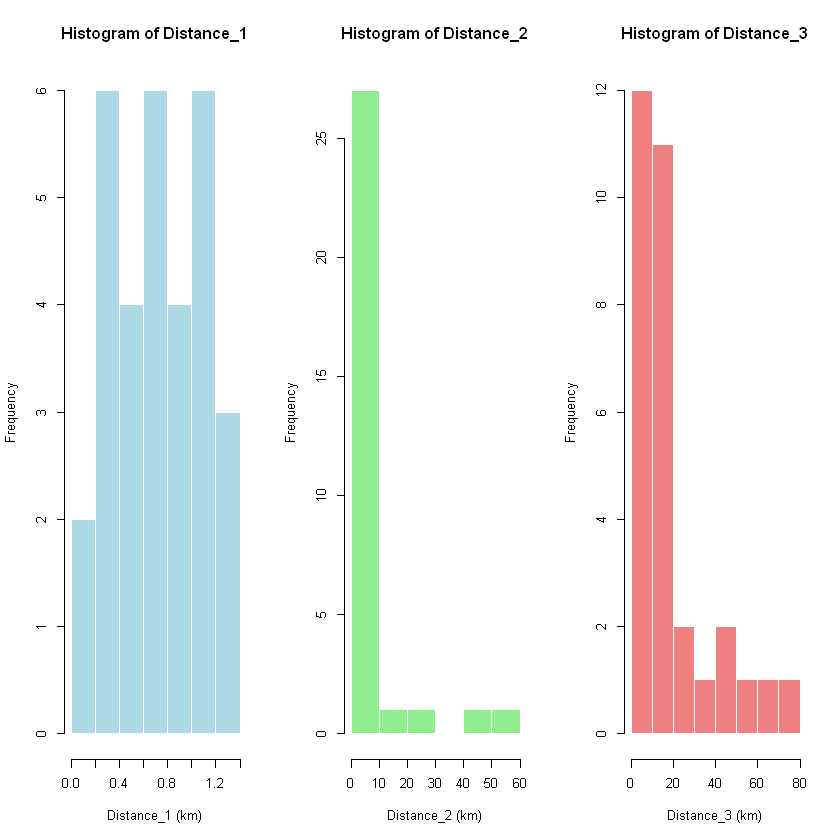

In [8]:
# Set up a 1-row, 3-column layout for the histograms
par(mfrow = c(1, 3))

# Plot the histogram for the first nearest distance
hist(as.numeric(final_data$Distance_1), 
     main = "Histogram of Distance_1", 
     xlab = "Distance_1 (km)", 
     ylab = "Frequency", 
     col = "lightblue", 
     border = "white")

# Plot the histogram for the second nearest distance
hist(as.numeric(final_data$Distance_2), 
     main = "Histogram of Distance_2", 
     xlab = "Distance_2 (km)", 
     ylab = "Frequency", 
     col = "lightgreen", 
     border = "white")

# Plot the histogram for the third nearest distance
hist(as.numeric(final_data$Distance_3), 
     main = "Histogram of Distance_3", 
     xlab = "Distance_3 (km)", 
     ylab = "Frequency", 
     col = "lightcoral", 
     border = "white")

# Reset to the default single-plot layout
par(mfrow = c(1, 1))